In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 300

In [3]:
files = glob.glob("../data/*.csv")

# list of dataframes
dataframes = []

for f in files:
    dataframes.append(pd.read_csv(f))

In [4]:
data_list = []
minimum_rep = 1000
maximum_rep = 0
minimum_rep_info = 0, 'none'
maximum_rep_info = 0, 'none'

for index, df in enumerate(dataframes):
    df = df[~df.Movement.isin(['Start calibration', 'End calibration', 'Not movement', 'Seiso ylös sensor vaihto', 'Not movement inactive', 'Not movement active'])]
    sensor_placement_groups = df.groupby('SensorPlacement')
    left_sensor_df = sensor_placement_groups.get_group('left').copy()
    left_movement_groups = left_sensor_df.groupby("Movement", sort=False)

    for group_name, left_df in left_movement_groups:
        left_start_df = left_df[left_df["Start"] == 1].copy()
        left_start_df['index1'] = left_start_df.index
        left_start_df['diff'] = left_start_df['index1'].diff()
        left_start_df = left_start_df.iloc[1:]
        diff = left_start_df['diff']

        # User index = index
        # Movement = group name
        mean = diff.mean()
        std = diff.std()
        min = diff.min()
        max = diff.max()

        if min < minimum_rep:
            minimum_rep = min
            minimum_rep_info = index, group_name
        
        if max > maximum_rep:
            maximum_rep = max
            maximum_rep_info = index, group_name

        row = [index, group_name, mean, std, min, max]
        data_list.append(row)

In [5]:
length_df = pd.DataFrame(data_list, columns =['User', 'Movement', 'Mean', 'Std', 'Min', 'Max']) 

In [6]:
# Get info from length_df
# Average of averages is ok because everyone did 10 repso

movement_groups = length_df.groupby("Movement")
movement_list = []

for group_name, mov_df in movement_groups:
    mean = mov_df['Mean'].mean()
    min = mov_df['Min'].min()
    max = mov_df['Max'].max()
    row = [group_name, mean, min, max]
    movement_list.append(row)


In [7]:
final_df = pd.DataFrame(movement_list, columns =['Movement', 'Mean', 'Min', 'Max']) 

In [8]:
final_df

,Movement,Mean,Min,Max
0,Jalka sivulle oikea,152.68,84.0,268.0
1,Jalka sivulle vasen,153.52,88.0,248.0
2,Jalka taakse oikea,165.28,88.0,304.0
3,Jalka taakse vasen,165.80,88.0,260.0
4,Jalkanosto oikea,164.84,100.0,280.0
5,Jalkanosto vasen,161.60,92.0,280.0
6,Polvinosto oikea,159.56,92.0,268.0
7,Polvinosto vasen,157.36,96.0,228.0
8,Seiso ylös,217.48,124.0,320.0
9,Varpaille,163.56,92.0,240.0


In [10]:
final_df['Mean'].mean()

166.168

In [60]:
half_movement_mean = round(final_df['Mean'].mean()/2)
third_minimum_movement = round(final_df['Min'].min()/3)

In [61]:
print("Minimum: ", minimum_rep_info)
print("Maximum: ", maximum_rep_info)

Minimum:  (4, 'Jalka sivulle oikea')
Maximum:  (5, 'Seiso ylös')


In [62]:
# Start dataframe times from zero

def zero_timestamps(df):
    df.loc[ : , "Timestamp"] -= df.iloc[0,0]

In [63]:
def zero_index(df):
    df.loc[ : , "index1"] -= df.iloc[0,-1]

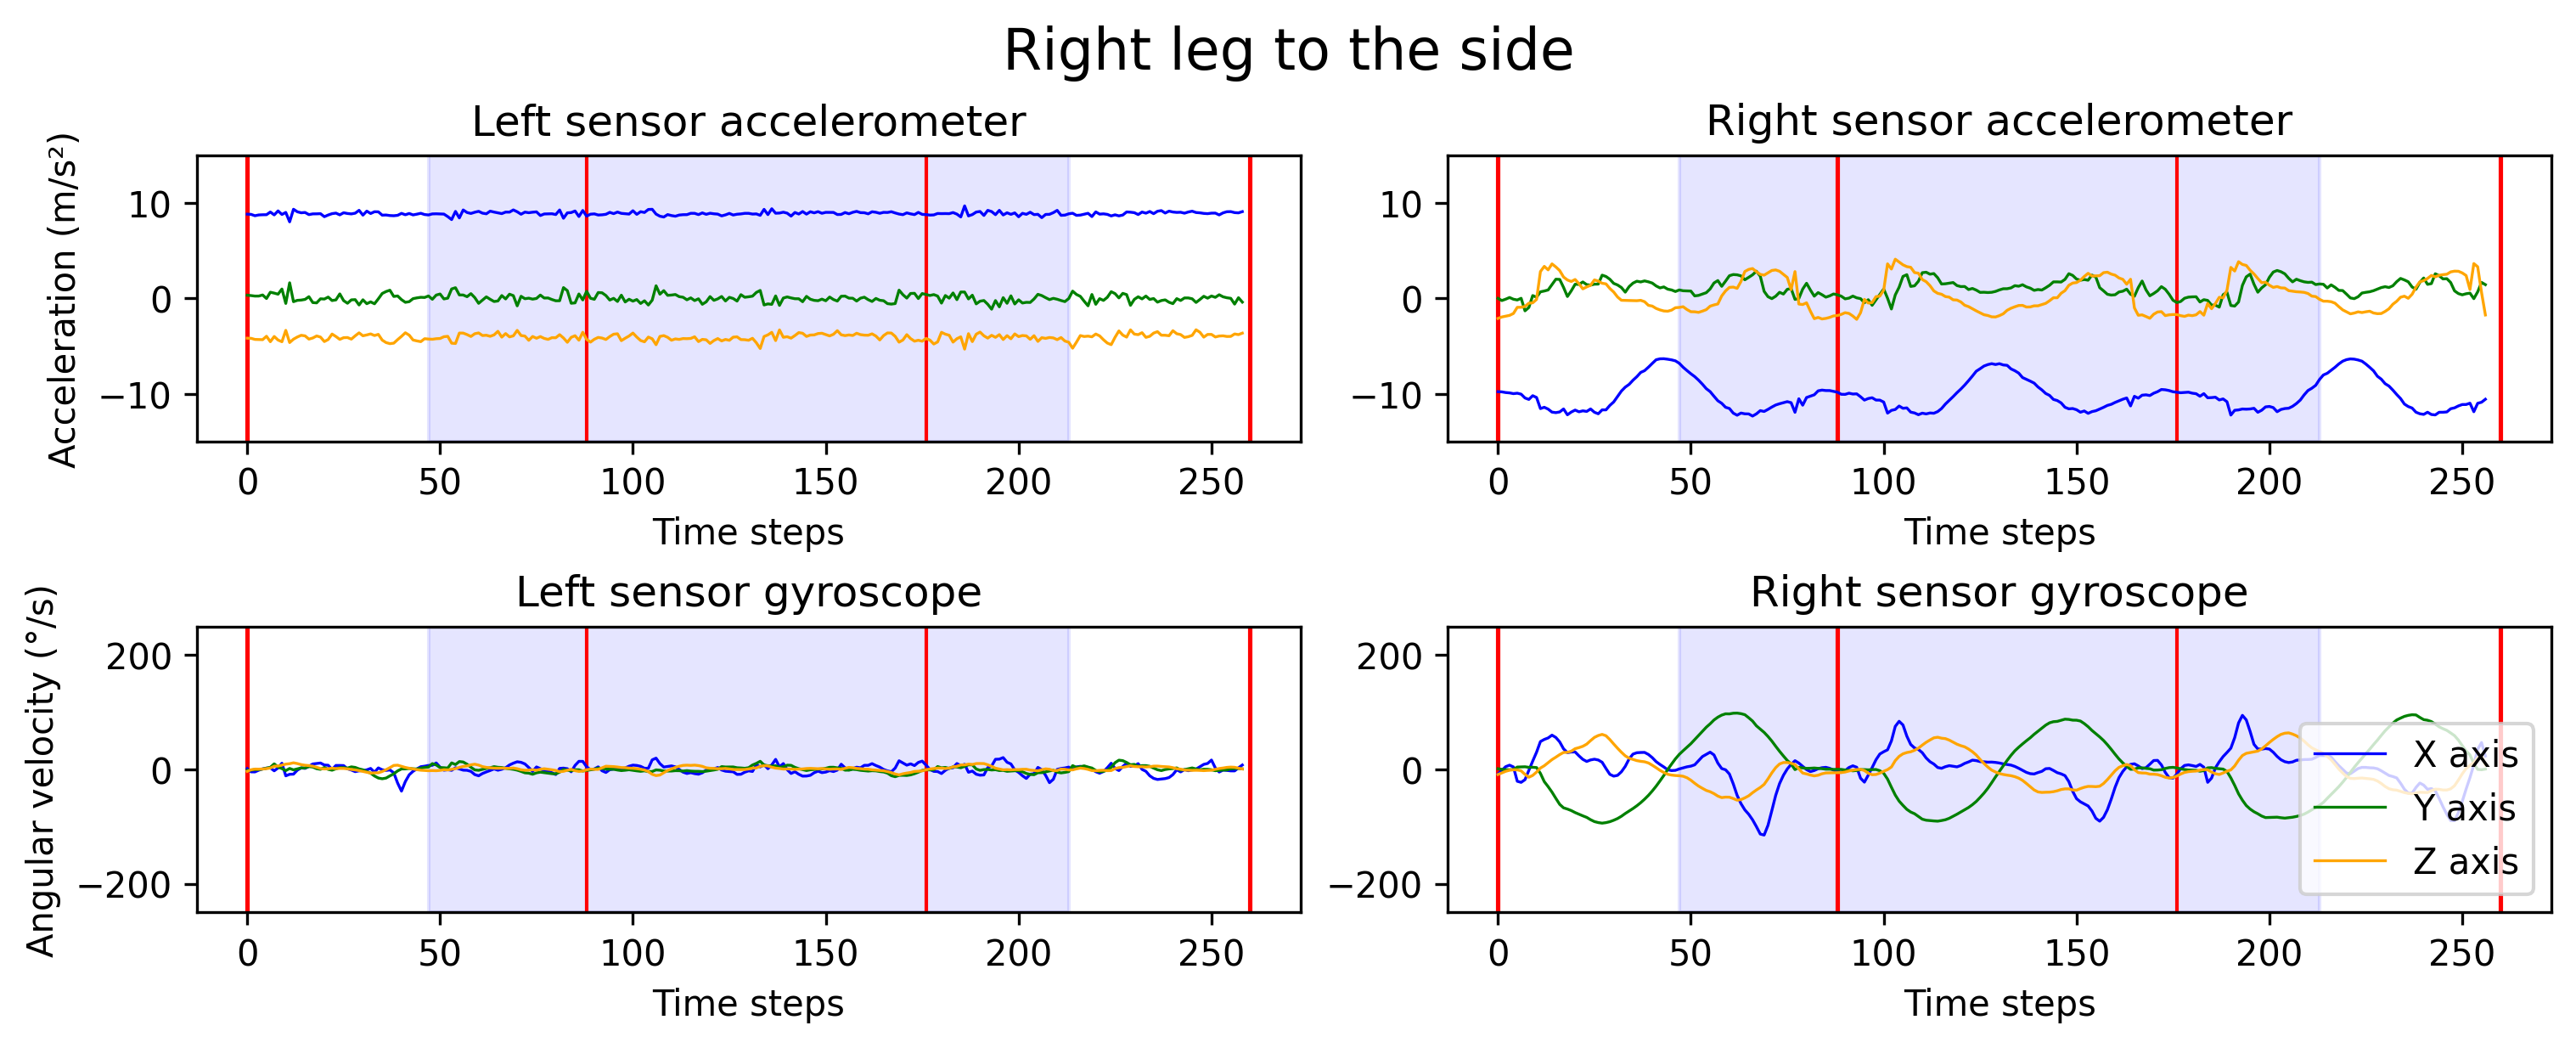

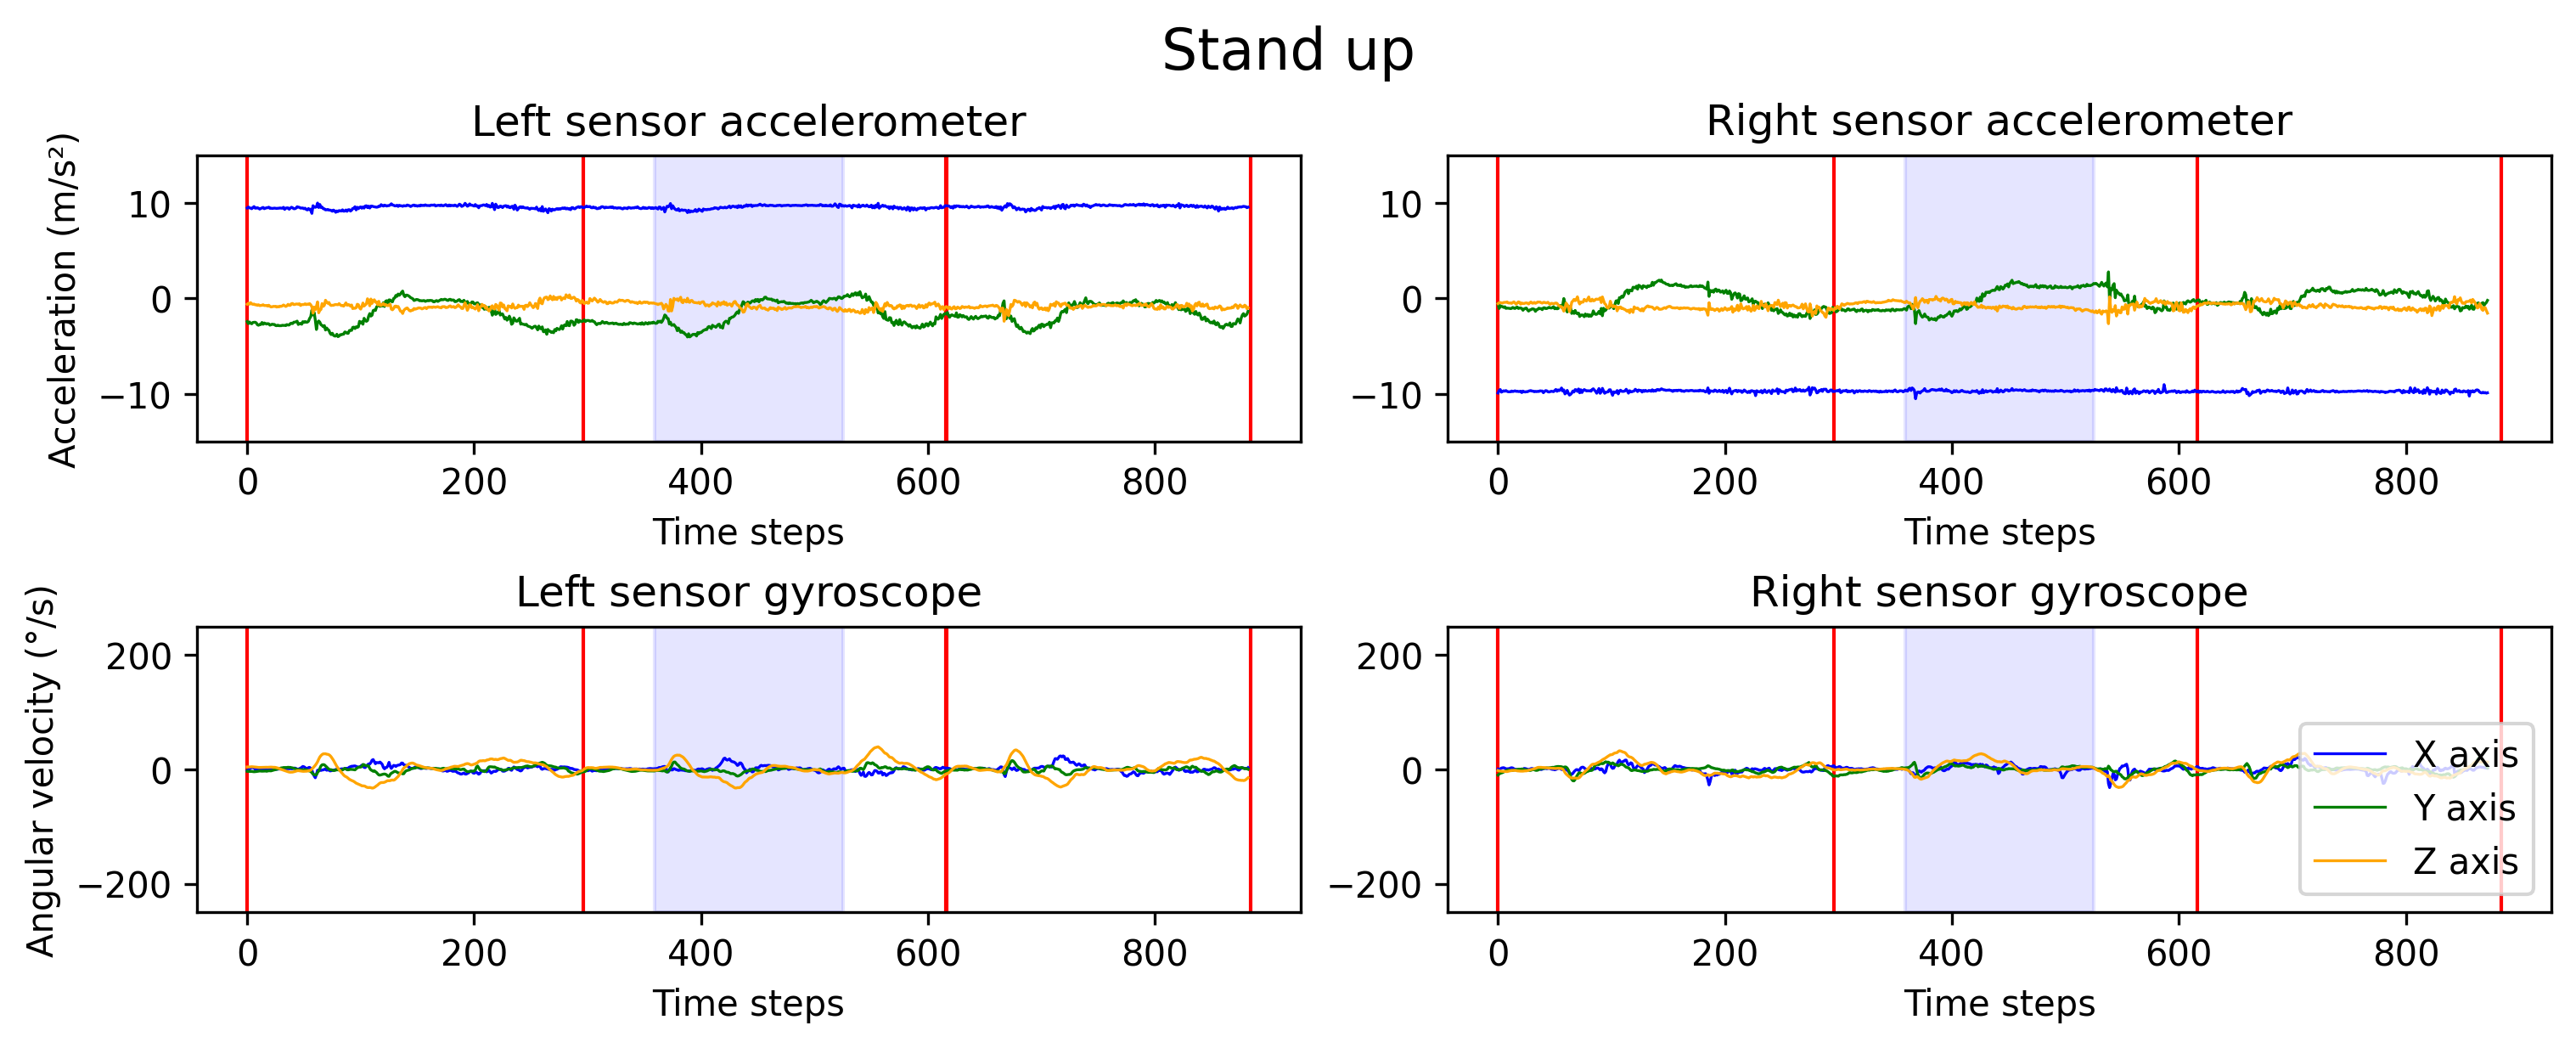

In [64]:
movement_translation_map = {
    'Jalka sivulle oikea': 'Right leg to the side',
    'Jalka sivulle vasen': 'Left leg to the side',
    'Jalka taakse oikea': 'Right leg back',
    'Jalka taakse vasen': 'Left leg back',
    'Jalkanosto oikea': 'Right leg lift',
    'Jalkanosto vasen': 'Left leg lift',
    'Not movement active': 'Null',
    'Polvinosto oikea': 'Right knee lift',
    'Polvinosto vasen': 'Left knee lift',
    'Seiso ylös': 'Stand up',
    'Varpaille': 'Toe raise',
}

for index, df in enumerate(dataframes):
    df = df[~df.Movement.isin(['Start calibration', 'End calibration', 'Not movement', 'Seiso ylös sensor vaihto', 'Not movement inactive', 'Not movement active'])]

    movement_groups = df.groupby("Movement", sort=False)

    for group_name, group_df in movement_groups:
        if index == minimum_rep_info[0] and group_name == minimum_rep_info[1] or index == maximum_rep_info[0] and group_name == maximum_rep_info[1]:

            # zero_timestamps(group_df)
            placement_groups = group_df.groupby("SensorPlacement")

            left_df = placement_groups.get_group('left')
            right_df = placement_groups.get_group('right')
            left_start_df = left_df[left_df["Start"] == 1]
            left_start_df = left_start_df.head(4)

            left_df = left_df.loc[(left_df["Timestamp"] > left_start_df.iloc[0,0]) & (left_df["Timestamp"] < left_start_df.iloc[-1, 0]), :]
            right_df = right_df.loc[(right_df["Timestamp"] > left_start_df.iloc[0,0]) & (right_df["Timestamp"] < left_start_df.iloc[-1, 0]), :]

            zero_timestamps(left_df)
            zero_timestamps(right_df)
            zero_timestamps(left_start_df)
            left_df.reset_index(drop=True, inplace=True)
            right_df.reset_index(drop=True, inplace=True)
            left_df['index1'] = left_df.index
            right_df['index1'] = right_df.index

            left_start_df['index1'] = left_start_df.index
            zero_index(left_start_df)


            figure, axis = plt.subplots(2, 2, constrained_layout = True)
            group_name_eng = movement_translation_map.get(group_name) 
            figure.suptitle(group_name_eng, fontsize=16)

            axis[0, 0].plot(left_df["index1"], left_df["AccX"], label='X axis', color='blue', linewidth=0.8)
            axis[0, 0].plot(left_df["index1"], left_df["AccY"], label='Y axis', color='green', linewidth=0.8)
            axis[0, 0].plot(left_df["index1"], left_df["AccZ"], label='Z axis', color='orange', linewidth=0.8)
            # axis[0].bar(left_start_df["Timestamp"], 30, 100, -15, label='start')
            axis[0, 0].set_ylim([-15, 15])
            axis[0, 0].set_title("Left sensor accelerometer")
            axis[0, 0].set_xlabel("Time steps")
            axis[0, 0].set_ylabel("Acceleration (m/s²)")

            axis[0, 1].plot(right_df["index1"], right_df["AccX"], label='X axis', color='blue', linewidth=0.8)
            axis[0, 1].plot(right_df["index1"], right_df["AccY"], label='Y axis', color='green', linewidth=0.8)
            axis[0, 1].plot(right_df["index1"], right_df["AccZ"], label='Z axis', color='orange', linewidth=0.8)
            # axis[1].bar(left_start_df["Timestamp"], 30, 100, -15, label='start')
            axis[0, 1].set_ylim([-15, 15])
            axis[0, 1].set_xlabel("Time steps")
            axis[0, 1].set_title("Right sensor accelerometer")

            axis[1, 0].plot(left_df["index1"], left_df["GyroX"], label='X axis', color='blue', linewidth=0.8)
            axis[1, 0].plot(left_df["index1"], left_df["GyroY"], label='Y axis', color='green', linewidth=0.8)
            axis[1, 0].plot(left_df["index1"], left_df["GyroZ"], label='Z axis', color='orange', linewidth=0.8)
            # axis[2].bar(left_start_df["Timestamp"], 300, 100, -150, label='start')
            axis[1, 0].set_ylim([-250, 250])
            axis[1, 0].set_title("Left sensor gyroscope")
            axis[1, 0].set_xlabel("Time steps")
            axis[1, 0].set_ylabel("Angular velocity (°/s)")

            axis[1, 1].plot(right_df["index1"], right_df["GyroX"], label='X axis', color='blue', linewidth=0.8)
            axis[1, 1].plot(right_df["index1"], right_df["GyroY"], label='Y axis', color='green', linewidth=0.8)
            axis[1, 1].plot(right_df["index1"], right_df["GyroZ"], label='Z axis', color='orange', linewidth=0.8)
            # axis[3].bar(left_start_df["Timestamp"], 300, 100, -150, label='start')
            axis[1, 1].set_ylim([-250, 250])
            axis[1, 1].set_title("Right sensor gyroscope")
            axis[1, 1].set_xlabel("Time steps")

            axis[0, 0].axvspan(round(left_start_df['index1'].iloc[-1]/2) - half_movement_mean, round(left_start_df['index1'].iloc[-1]/2) + half_movement_mean, color = 'blue', alpha = 0.1)
            axis[0, 1].axvspan(round(left_start_df['index1'].iloc[-1]/2) - half_movement_mean, round(left_start_df['index1'].iloc[-1]/2) + half_movement_mean, color = 'blue', alpha = 0.1)
            axis[1, 0].axvspan(round(left_start_df['index1'].iloc[-1]/2) - half_movement_mean, round(left_start_df['index1'].iloc[-1]/2) + half_movement_mean, color = 'blue', alpha = 0.1)
            axis[1, 1].axvspan(round(left_start_df['index1'].iloc[-1]/2) - half_movement_mean, round(left_start_df['index1'].iloc[-1]/2) + half_movement_mean, color = 'blue', alpha = 0.1)

            for pause in left_start_df["index1"]:
                axis[0, 0].axvspan(pause, pause + 0.1, color = 'red')
                axis[0, 1].axvspan(pause, pause + 0.1, color = 'red')
                axis[1, 0].axvspan(pause, pause + 0.1, color = 'red')
                axis[1, 1].axvspan(pause, pause + 0.1, color = 'red')

            plt.legend(loc="lower right")
            plt.show()


# Repetition window visualization

In [65]:
WINDOW_SIZE = third_minimum_movement
WINDOW_STRIDE = round(third_minimum_movement/3)

print(f'Window size: {WINDOW_SIZE}')
print(f'Window stride: {WINDOW_STRIDE}')


Window size: 28
Window stride: 9


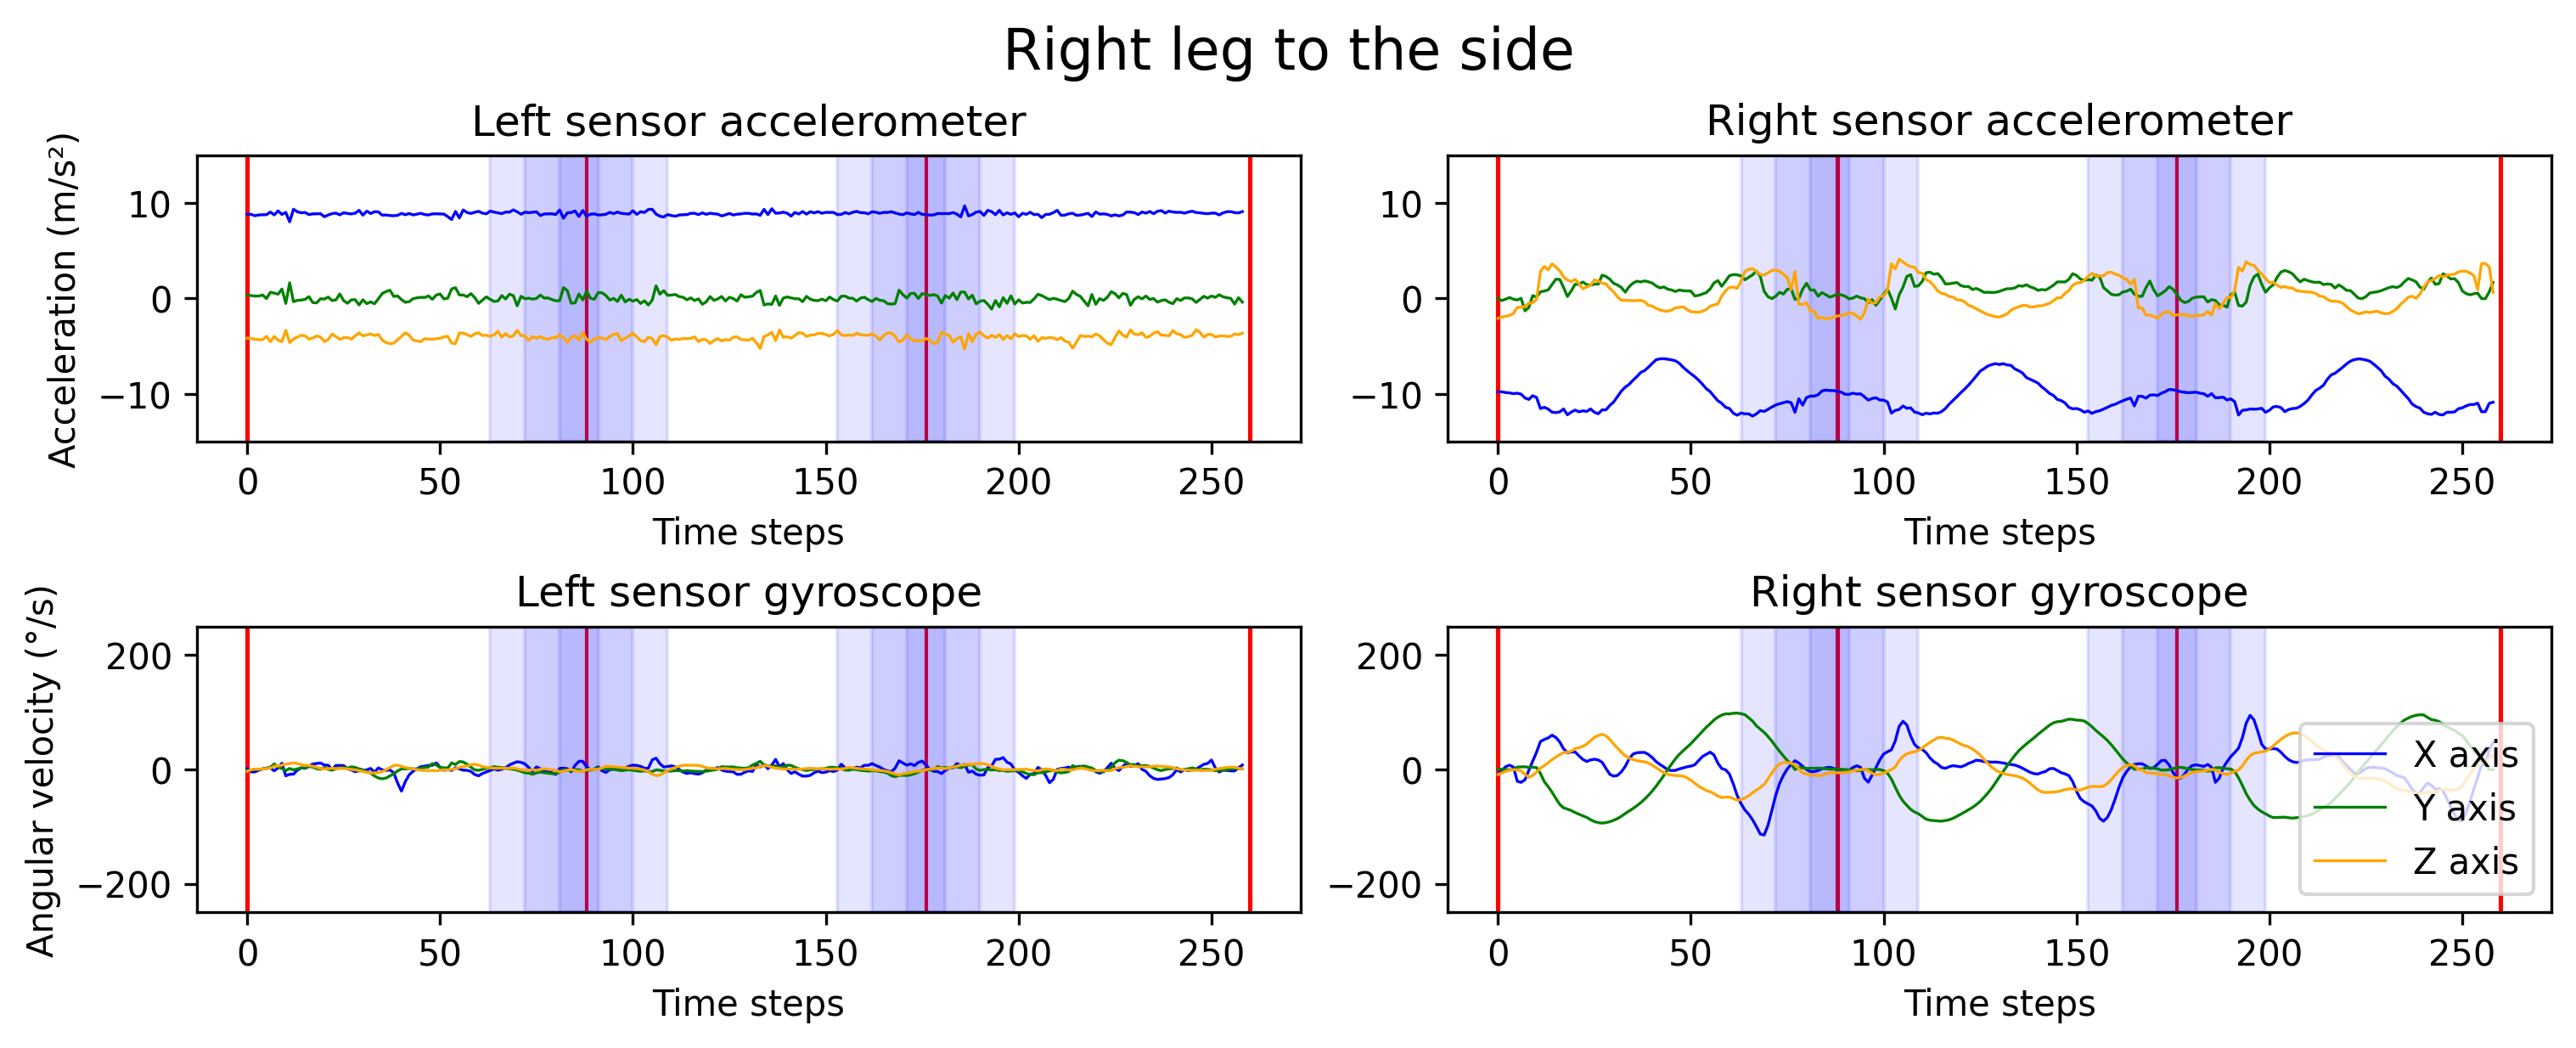

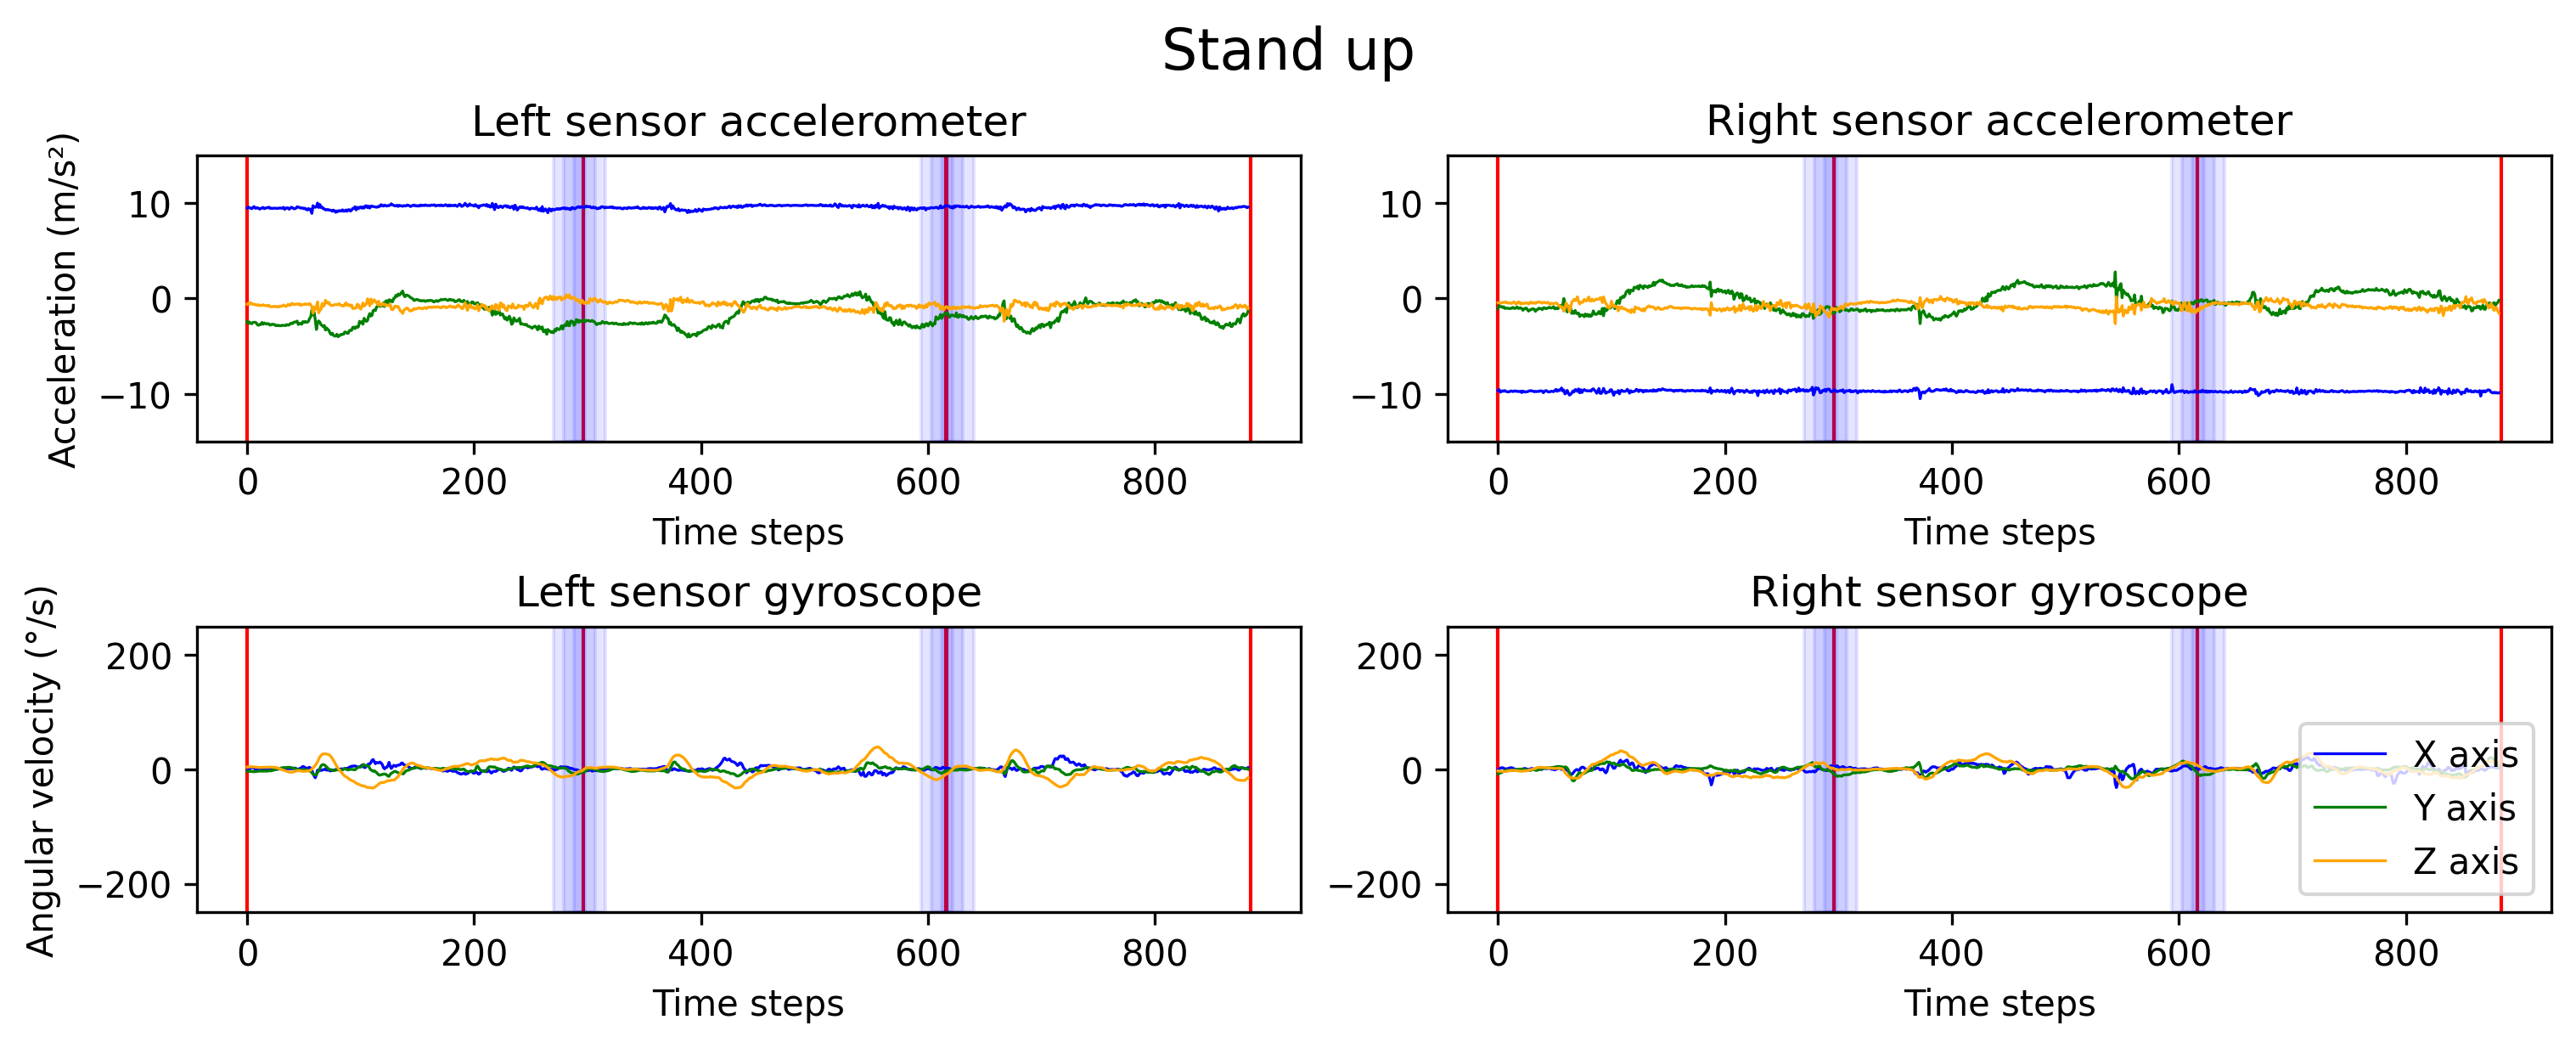

In [66]:
movement_translation_map = {
    'Jalka sivulle oikea': 'Right leg to the side',
    'Jalka sivulle vasen': 'Left leg to the side',
    'Jalka taakse oikea': 'Right leg back',
    'Jalka taakse vasen': 'Left leg back',
    'Jalkanosto oikea': 'Right leg lift',
    'Jalkanosto vasen': 'Left leg lift',
    'Not movement active': 'Null',
    'Polvinosto oikea': 'Right knee lift',
    'Polvinosto vasen': 'Left knee lift',
    'Seiso ylös': 'Stand up',
    'Varpaille': 'Toe raise',
}

shortest_labels = []
longest_labels = []

for index, df in enumerate(dataframes):

    df = df[~df.Movement.isin(['Start calibration', 'End calibration', 'Not movement', 'Not movement inactive', 'Not movement active', 'Seiso ylös sensor vaihto'])]
    sensor_placement_groups = df.groupby('SensorPlacement')
    left_sensor_df = sensor_placement_groups.get_group('left').copy()
    right_sensor_df = sensor_placement_groups.get_group('right').copy()

    left_movement_groups = left_sensor_df.groupby("Movement", sort=False)
    right_movement_groups = right_sensor_df.groupby("Movement", sort=False)

    for group_name, left_df in left_movement_groups:

        if index == minimum_rep_info[0] and group_name == minimum_rep_info[1] or index == maximum_rep_info[0] and group_name == maximum_rep_info[1]:

            right_df = right_movement_groups.get_group(group_name)

            left_df = left_df.sort_values(by=['Timestamp'])
            right_df = right_df.sort_values(by=['Timestamp'])

            left_df.drop(['SensorPlacement', 'MagnX', 'MagnY', 'MagnZ'], axis=1, inplace=True)
            left_df.rename(columns = {'AccX':'lax', 'AccY':'lay', 'AccZ':'laz', 'GyroX':'lgx', 'GyroY':'lgy', 'GyroZ':'lgz'}, inplace = True)

            right_df.drop(['Movement', 'SensorPlacement', 'Start', 'MagnX', 'MagnY', 'MagnZ'], axis=1, inplace=True)
            right_df.rename(columns = {'AccX':'rax', 'AccY':'ray', 'AccZ':'raz', 'GyroX':'rgx', 'GyroY':'rgy', 'GyroZ':'rgz',}, inplace = True)

            combined_df = pd.merge_asof(left_df, right_df, on='Timestamp', direction='nearest')

            start_df = combined_df[combined_df["Start"] == 1]

            start_df = start_df.head(4)

            combined_df = combined_df.loc[(combined_df["Timestamp"] > start_df.iloc[0,0]) & (combined_df["Timestamp"] < start_df.iloc[-1, 0]), :]

            if group_name == minimum_rep_info[1]:
                for i in range(0, len(combined_df) - WINDOW_SIZE, WINDOW_STRIDE):
                    window_df = combined_df.iloc[i:i+WINDOW_SIZE].copy()
                    shortest_labels.append(window_df['Start'].values.max())
                    pause_label_df = pd.DataFrame({'Label': shortest_labels})

            if group_name == maximum_rep_info[1]:
                for i in range(0, len(combined_df) - WINDOW_SIZE, WINDOW_STRIDE):
                    window_df = combined_df.iloc[i:i+WINDOW_SIZE].copy()
                    longest_labels.append(window_df['Start'].values.max())
                    pause_label_df = pd.DataFrame({'Label': longest_labels})
            
            # Add original index for plotting later
            pause_label_df['original_index'] = combined_df.index[0] + (pause_label_df.index * WINDOW_STRIDE)

            zero_timestamps(combined_df)
            zero_timestamps(start_df)

            pause_label_df.loc[ : , "original_index"] -= combined_df.index[0]
            pause_label_df = pause_label_df[pause_label_df.Label != 0]

            combined_df.reset_index(drop=True, inplace=True)
            combined_df['index1'] = combined_df.index

            start_df['index1'] = start_df.index
            zero_index(start_df)

            figure, axis = plt.subplots(2, 2, constrained_layout = True)
            group_name_eng = movement_translation_map.get(group_name) 
            figure.suptitle(group_name_eng, fontsize=16)

            axis[0, 0].plot(combined_df["index1"], combined_df["lax"], label='X axis', color='blue', linewidth=0.8)
            axis[0, 0].plot(combined_df["index1"], combined_df["lay"], label='Y axis', color='green', linewidth=0.8)
            axis[0, 0].plot(combined_df["index1"], combined_df["laz"], label='Z axis', color='orange', linewidth=0.8)
            # axis[0].bar(left_start_df["Timestamp"], 30, 100, -15, label='start')
            axis[0, 0].set_ylim([-15, 15])
            axis[0, 0].set_title("Left sensor accelerometer")
            axis[0, 0].set_xlabel("Time steps")
            axis[0, 0].set_ylabel("Acceleration (m/s²)")

            axis[0, 1].plot(combined_df["index1"], combined_df["rax"], label='X axis', color='blue', linewidth=0.8)
            axis[0, 1].plot(combined_df["index1"], combined_df["ray"], label='Y axis', color='green', linewidth=0.8)
            axis[0, 1].plot(combined_df["index1"], combined_df["raz"], label='Z axis', color='orange', linewidth=0.8)
            # axis[1].bar(left_start_df["Timestamp"], 30, 100, -15, label='start')
            axis[0, 1].set_ylim([-15, 15])
            axis[0, 1].set_title("Right sensor accelerometer")
            axis[0, 1].set_xlabel("Time steps")

            axis[1, 0].plot(combined_df["index1"], combined_df["lgx"], label='X axis', color='blue', linewidth=0.8)
            axis[1, 0].plot(combined_df["index1"], combined_df["lgy"], label='Y axis', color='green', linewidth=0.8)
            axis[1, 0].plot(combined_df["index1"], combined_df["lgz"], label='Z axis', color='orange', linewidth=0.8)
            # axis[2].bar(left_start_df["Timestamp"], 300, 100, -150, label='start')
            axis[1, 0].set_ylim([-250, 250])
            axis[1, 0].set_title("Left sensor gyroscope")
            axis[1, 0].set_ylabel("Angular velocity (°/s)")
            axis[1, 0].set_xlabel("Time steps")

            axis[1, 1].plot(combined_df["index1"], combined_df["rgx"], label='X axis', color='blue', linewidth=0.8)
            axis[1, 1].plot(combined_df["index1"], combined_df["rgy"], label='Y axis', color='green', linewidth=0.8)
            axis[1, 1].plot(combined_df["index1"], combined_df["rgz"], label='Z axis', color='orange', linewidth=0.8)
            # axis[3].bar(left_start_df["Timestamp"], 300, 100, -150, label='start')
            axis[1, 1].set_ylim([-250, 250])
            axis[1, 1].set_title("Right sensor gyroscope")
            axis[1, 1].set_xlabel("Time steps")

            # axis[0, 0].axvspan(200, 400, color = 'blue', alpha = 0.1)
            # axis[0, 1].axvspan(200, 400, color = 'blue', alpha = 0.1)
            # axis[1, 0].axvspan(200, 400, color = 'blue', alpha = 0.1)
            # axis[1, 1].axvspan(200, 400, color = 'blue', alpha = 0.1)

            for pause in start_df["index1"]:
                axis[0, 0].axvspan(pause, pause + 0.1, color = 'red')
                axis[0, 1].axvspan(pause, pause + 0.1, color = 'red')
                axis[1, 0].axvspan(pause, pause + 0.1, color = 'red')
                axis[1, 1].axvspan(pause, pause + 0.1, color = 'red')

            for window_start in pause_label_df["original_index"]:
                axis[0, 0].axvspan(window_start, window_start + WINDOW_SIZE, color = 'blue', alpha=0.1)
                axis[0, 1].axvspan(window_start, window_start + WINDOW_SIZE, color = 'blue', alpha=0.1)
                axis[1, 0].axvspan(window_start, window_start + WINDOW_SIZE, color = 'blue', alpha=0.1)
                axis[1, 1].axvspan(window_start, window_start + WINDOW_SIZE, color = 'blue', alpha=0.1)

            plt.legend(loc="lower right")
            plt.show()

